In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from CoolProp.CoolProp import PropsSI
import CoolProp.CoolProp
 

In [2]:
#Tank Parameters
g = 9.81
n_nodes = 5
h_tank = 36.57 #tank height (m)
w_tank = 8.38 #tank width (m)
d_tank = 8.38 #tank depth (m)
Ul = 0.1 #Percent of Ulage Volume
t_range = (0,75)

# Vibration frequences and amplitudes
omega_array = np.array([1,5,10,25,50,75,100,150,250,300,500,600,750])*2*np.pi #Vibration Ang. Freq (rad/s)
A_m_array = [] #Amplitude of the Vibration (m)
vib_acc = 9.81 #Acceleration of the Vibration (m/s^2)
for i in range(len(omega_array)):
    A_m_array.append(vib_acc/omega_array[i]**2)
phi_f = 0 #Vibration Inital Phase

#Solution Information
Delta_t = 1e-4 #Numerical Method Timestep
u0 = np.zeros(2*n_nodes) #Initial Conditions for each node

In [3]:
#Propellant Parameters Function
def get_fluid_prop(P,T,Fluid):
    rho = PropsSI('D', 'P', P, 'T', T, Fluid) #Fluid density (kg/m^3)
    mu = PropsSI('V', 'P', P, 'T', T, Fluid) #Fluid dynamic viscocity (Pa*s)
    return rho,mu
#rho_water, mu_water = get_fluid_prop(P_tank,T_tank,Prop_type)


In [4]:
def Matrix(P,T,Fluid,nodes,omega_f,A_m,Perc_ul=Ul):
    """Returns the coeffcient matrices 

    Parameters
    ----------
    P : float_like
        Pressure at which the fluid i stored in the tank (Pa) 
    T : float_like
        Temperature of the fluid (K)
    Fluid : string
        Name of the fluid in Coolprop 
    Nodes : int
        Number of vibration modes 
    omega_f: float_like
        Vibration Angular Frequency (rad/s)
    A_m : float_like
        Vibration Amplitude (m)

    Returns
    -------
    M : array_like
        Mass Matrix (kg)
    K : array_like 
        Spring Constant Matrix (N/m)
    
    """
    rho_liquid, mu_liquid= get_fluid_prop(P,T,Fluid)
    M_liquid_t = (1-Perc_ul)*h_tank*w_tank*d_tank*rho_liquid #total mass of liquid in the tank (kg)
    h_liquid = (1-Perc_ul)*h_tank #height of the liquid in the tank (m)
    r = h_liquid/w_tank #ratio of water level to tank width 
    M = np.zeros((nodes,nodes)) # Mass matrix
    K = np.zeros((nodes,nodes)) # K matrix (spring constants)
    C1 = np.zeros((nodes,nodes))
    C2 = np.zeros((nodes,nodes))
    A = np.zeros(nodes)
    M_liquid_vib = 0 # Mass of fluid that oscillates (kg)
    for i in range(nodes):
        m_i = M_liquid_t*((8*np.tanh((2*i-1)*np.pi*r))/(np.pi**3*r*(2*i-1)**3))
        omega_sq_i = (g*(2*i-1)*np.pi*np.tanh((2*i-1)*np.pi*r))/(w_tank)
        ksi_i = np.sqrt(2*np.sqrt(omega_sq_i)*mu_liquid)*(1+2*h_liquid/d_tank)*w_tank/(4*np.pi*h_liquid/np.sqrt(g*h_liquid))
        c_1_i  = 2*m_i*np.sqrt(omega_sq_i)*ksi_i
        M_liquid_vib+=m_i
        C1[i,i] = c_1_i
        M[i,i] = m_i
        K[i,i] = omega_sq_i*m_i
        C2[i,i] = 0.1
        A[i] = m_i*A_m*omega_f**2


    m_0 = M_liquid_t - M_liquid_vib # Mass of fluid that remains stationary 
    return M, K, C1, C2, A, m_0


In [5]:
def f(t,u,matrices,omega_f,phi_f):
    """Returns the time derivative of u 

    Parameters
    ----------
    t : float_like
        Time 
    u : array_like
        Value of u evaluated at t
    omega_f: float_like
        Forcing Angular Frequency 
    phi_f : int
        Forcing Initial Phase
    

    Returns
    -------
    u_dot : array_like
        the value of u_dot evaluated at time t
    """
    
    M,K,C1,C2,A = matrices[0:5]
    u_dot = np.zeros((len(u)))
    q = u[0:int(len(u)/2)]
    q_dot = u[int(len(u)/2):]
    u_dot [0:int(len(u)/2)] = q_dot
    u_dot [int(len(u)/2):] = np.linalg.inv(M)@(A*np.sin(omega_f*t+phi_f)-C1@q_dot-K@q-C2@(q*q))
    return u_dot

In [6]:
def rk4(f,tn,un,Delta_t,matrices,omega_f,phi_f):
    """Returns the approximate value of u at tn+Delta_t using RK4 method

    Parameters
    ----------
    f : function 
        The time derivative of u at the points tn and un. f(tn,un) = u_dot(tn,un)
    tn : float_like
        time after nth timesteps
    un : array_like
        approximate value of u at tn
    Delta_t: float_like
        timestep 

    Returns
    -------
    u_next : array_like
        approximate value of u at tn+Delta_t
    """
    k1 = f(tn,un,matrices,omega_f,phi_f)
    k2 = f(tn+0.5*Delta_t,un+k1*Delta_t,matrices,omega_f,phi_f)
    k3 = f(tn+0.5*Delta_t,un+k2*Delta_t,matrices,omega_f,phi_f)
    k4 = f(tn+Delta_t,un+k3*Delta_t,matrices,omega_f,phi_f)
    u_next = un + Delta_t/6 * (k1+2*k2+2*k3+k4)
    return u_next


In [7]:
def solveIVP(f,t_range,u0,Delta_t,solver,matrices,omega_f,phi_f):
    """Returns the approximate solution of a given IVP using a given solver
    
    Parameters
    ----------
    f : function 
        The time derivative of u at the points tn and un. f(tn,un) = u_dot(tn,un)
    t_range: tuple
        Contains the initial (index = 0) and final time (index = 1)
    u0 : array_like
        Contains the initial value of u
    Delta_t : float_like
        Timestep 
    solver : function
        Solver used to calculate the value of u at tn+Delta_t
    matrices : tuple
        Contains the matrices with the equation coefficients
    omega : float_like
        Angular frequency of vibration
    phi_f : float_like 
        Initial phase of the vibration 

    Returns
    -------
    u : array_like
        Contains the values of u as a function of time
        """
    
    t = np.arange(t_range[0],t_range[1]+Delta_t,Delta_t)
    u = np.zeros((len(u0),len(t)))
    u[:,0] = u0

    for n in range(len(t)-1):
        u[:,n+1] = solver(f,t[n],u[:,n],Delta_t,matrices,omega_f,phi_f)

    return u,t


In [8]:
def Disp(Coeff_M,freq_ind,Delta_t):
    """Calculates the displacement as a function of time
    
    Parameters
    ----------
    Coeff_M : tuple
        Contains the coefficient matrices used for the solution of the IVP
    freq_ind: int
        index for frequences
    Delta_t : float_like
        Timestep

    Returns
    -------
    q : array_like
        Displacement of each mode as a function of time
    t : array_like
        Array containing all the times
    cm : array_like 
        Displacement of the center of mass as a function of time """
    
    u,t = solveIVP(f,t_range,u0,Delta_t,rk4,Coeff_M,omega_array[freq_ind],phi_f)
    q = u[:n_nodes,:]
    M = Coeff_M[0]
    m_O = float(Coeff_M[5])

    cm = np.zeros(len(t))
    for i in range(len(t)):
        cm_i = 0
        m_vib = 0
        for j in range(n_nodes):
            m_vib += M[j,j]
            cm_i += M[j,j]*q[j,i]
        m_tot = m_vib+m_O
        cm[i] = cm_i/m_tot
    return q,t,cm

In [9]:
def RK4_error(Coeff_M,freq_ind,Delta_t_range,Delta_t_base):
    """Calculates the error give a baseline Delta t
    
    Parameters
    ----------
    Coeff_M : tuple
        Contains the coefficient matrices used for the solution of the IVP
    freq_ind: int
        index for frequences
    Delta_t_array : array_like
        Contains all the timesteps at which the error is evaluated
    Delta_t_base : float_like
        Baseline Delta t

    Returns
    -------
    err_array: array_like
        Error as a function of Delta t"""
    
    cm_base = Disp(Coeff_M,freq_ind,Delta_t_base)[2]
    err_array = np.zeros(len(Delta_t_range))
    for i in range(len(Delta_t_range)):
        cm_i = Disp(Coeff_M,freq_ind,Delta_t_range[i])[2]
        err_i = np.linalg.norm(cm_i[-1] - cm_base[-1]) / np.linalg.norm(cm_base[-1])
        err_array[i]= err_i
    return err_array

In [10]:
ind = 1 #change that to get different omegas

#---Hydrogen Props----------------------------------
T_H2 = 21.15 #Propellant Temperature (K)
P_H2 = 241317 #Tank Pressure (Pa)
H2_name = "Hydrogen" #Name of the fluid (Should exist in coolprop)

Matrix_H2 =  Matrix(P_H2,T_H2,H2_name,n_nodes,omega_array[ind],A_m_array[ind])


#---Methane Props------------------------------------
T_CH4 = 111.15 #Propellant Temperature (K)
P_CH4 = 600000 #Tank Pressure (Pa)
CH4_name = "Methane" #Name of the fluid (Should exist in coolprop)

Matrix_CH4 = Matrix(P_CH4,T_CH4,CH4_name,n_nodes,omega_array[ind],A_m_array[ind]) 

#---Oxygen Props------------------------------------

T_O2 = 91.15 #Propellant Temperature (K)
P_O2 = 170000 #Tank Pressure (Pa)
O2_name = "Oxygen" #Name of the fluid (Should exist in coolprop)

Matrix_O2 = Matrix(P_O2,T_O2,O2_name,n_nodes,omega_array[ind],A_m_array[ind])

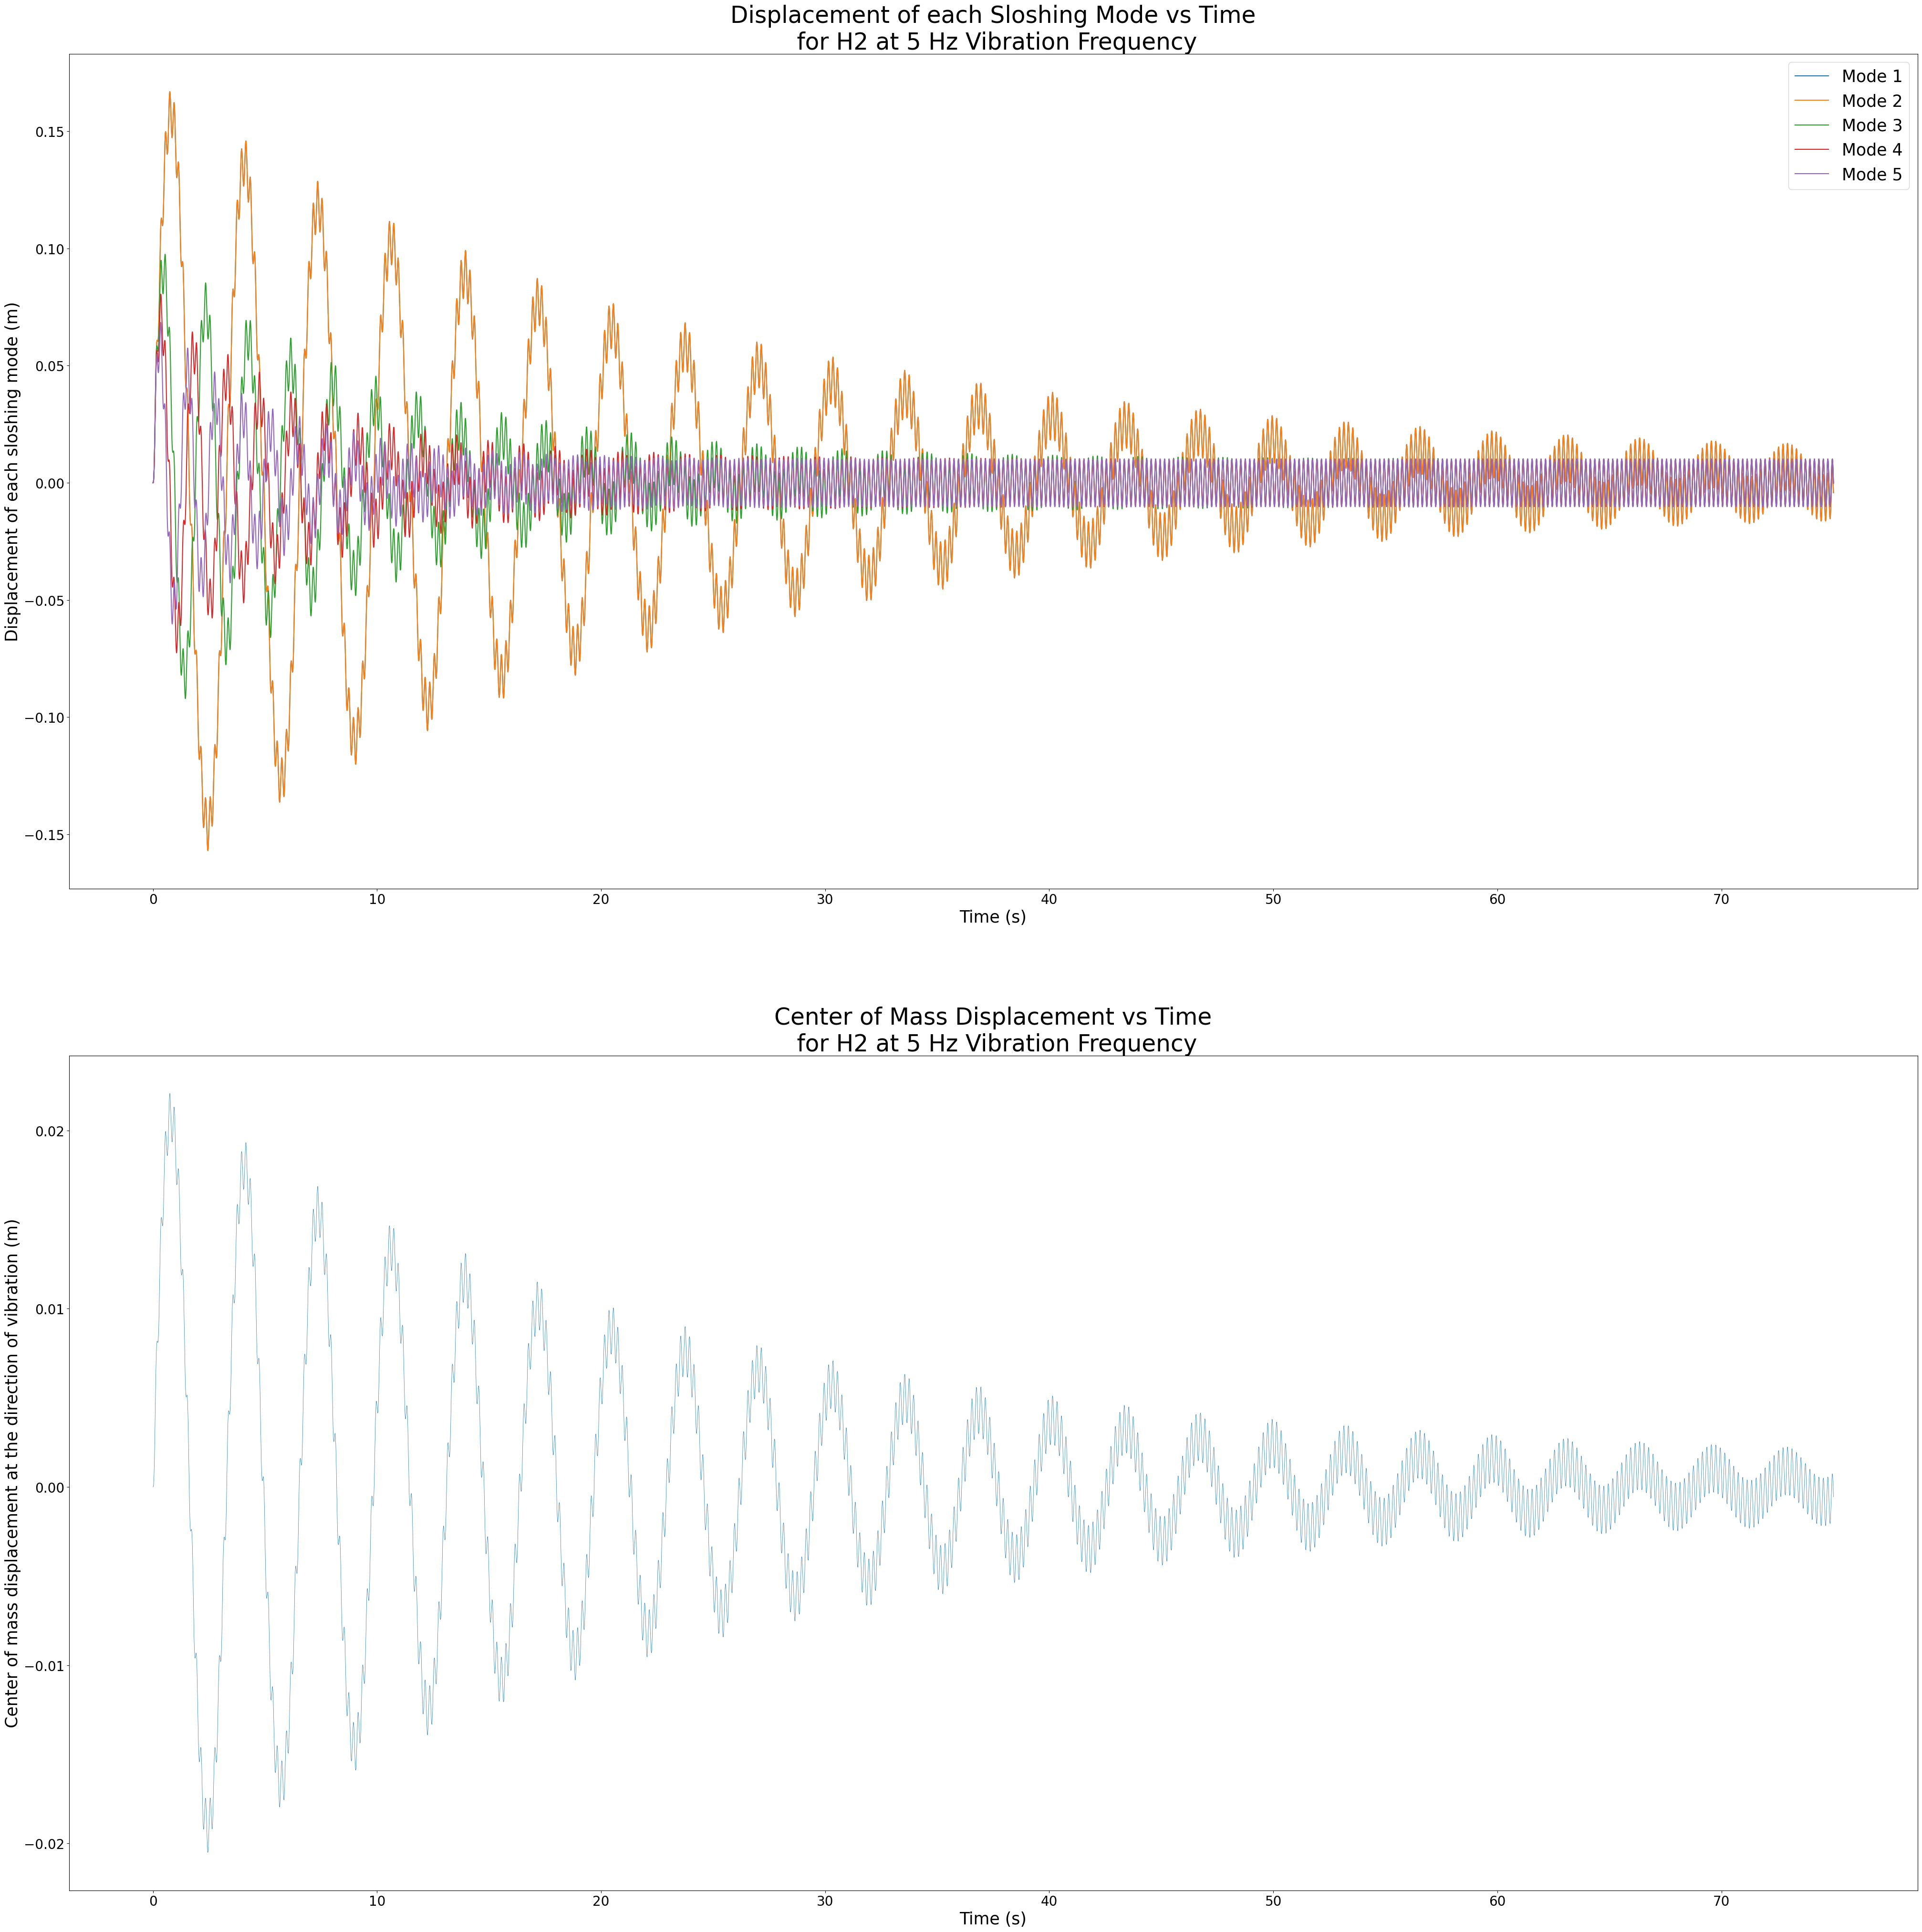

In [11]:
fig1, (ax1,ax2) = plt.subplots(2,1,figsize=(50,50))

q_h2,t_H2,cm_h2 = Disp(Matrix_H2,ind,Delta_t)


for j in range(n_nodes):
    ax1.plot(t_H2,q_h2[j,:],label=f"Mode {j+1}")

ax1.set_title("Displacement of each Sloshing Mode vs Time\n for H2 at 5 Hz Vibration Frequency",fontsize = 35)
ax1.set_ylabel("Displacement of each sloshing mode (m)",fontsize = 25)
ax1.set_xlabel("Time (s)",fontsize = 25)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.legend(fontsize = 25)

ax2.plot(t_H2,cm_h2,linewidth =0.5)
ax2.set_title("Center of Mass Displacement vs Time\n for H2 at 5 Hz Vibration Frequency",fontsize = 35)
ax2.set_ylabel("Center of mass displacement at the direction of vibration (m)",fontsize = 25)
ax2.set_xlabel("Time (s)",fontsize = 25)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

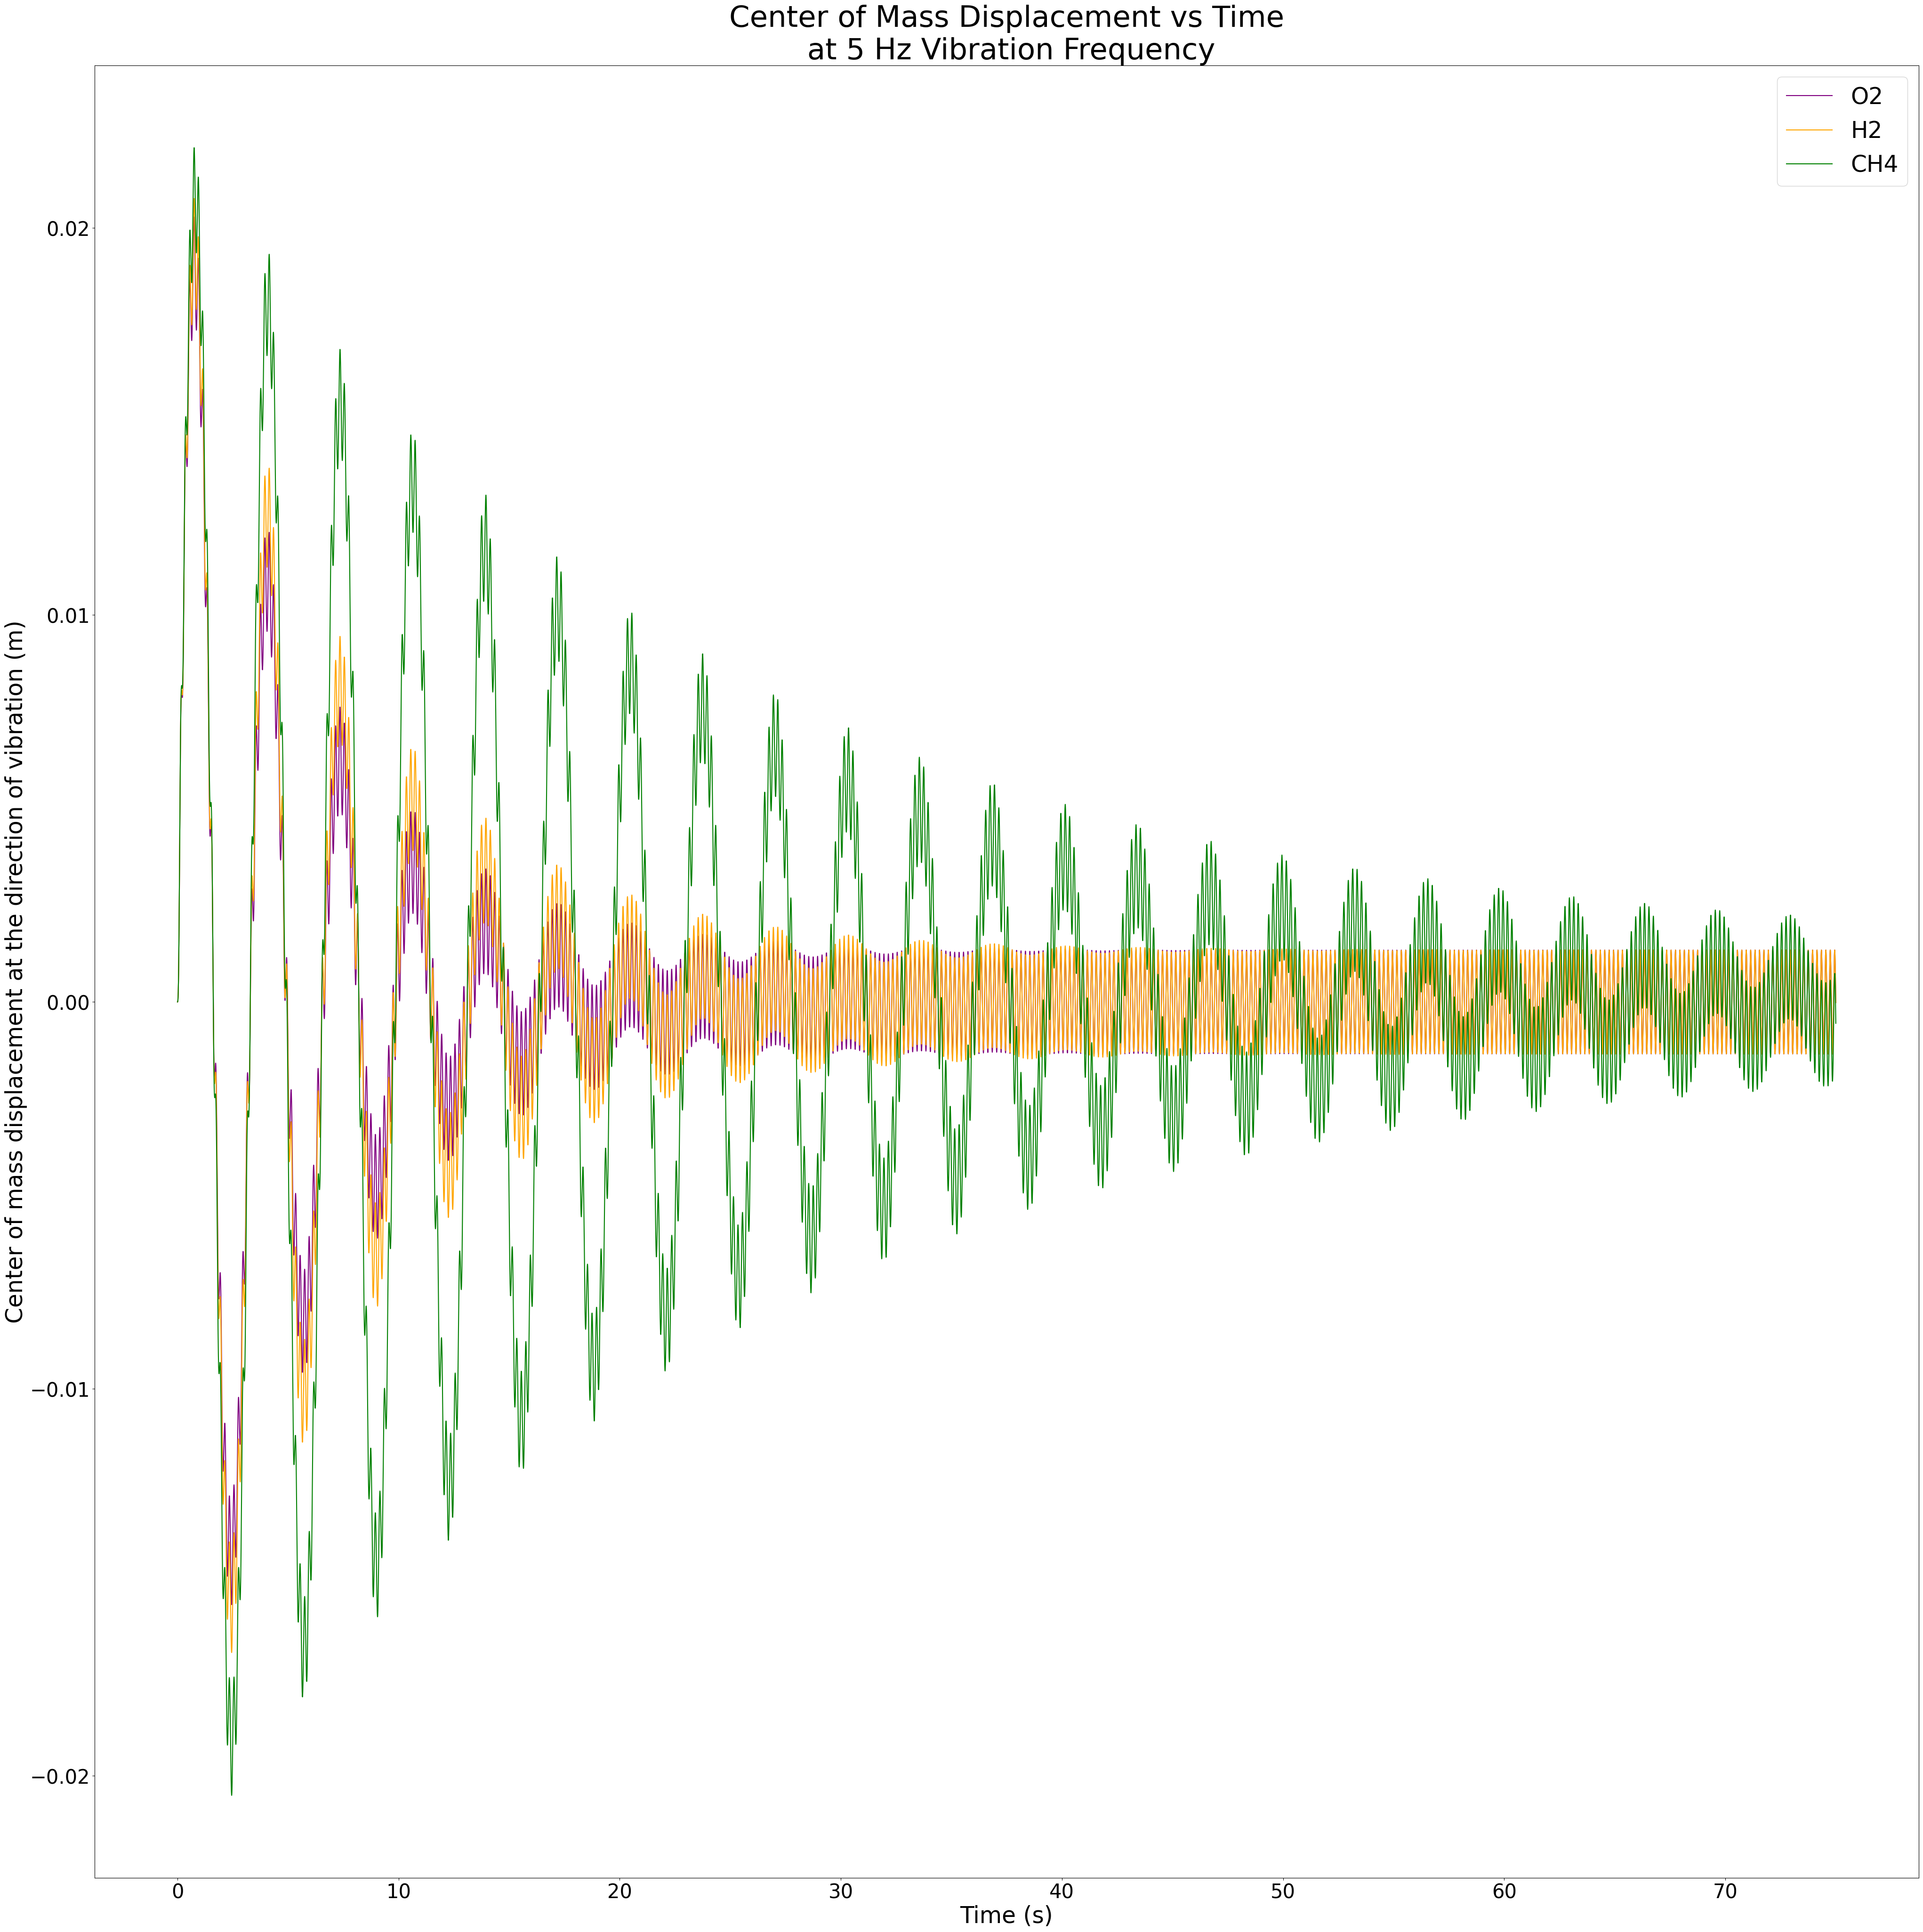

In [12]:
ind_2 = 1
Matrix_CH4_2 = Matrix(P_CH4,T_CH4,CH4_name,n_nodes,omega_array[ind_2],A_m_array[ind_2])
Matrix_H2_2 = Matrix(P_H2,T_H2,H2_name,n_nodes,omega_array[ind_2],A_m_array[ind_2])
Matrix_O2_2 = Matrix(P_O2,T_O2,O2_name,n_nodes,omega_array[ind_2],A_m_array[ind_2])

q_H2,t_H2,cm_H2 = Disp(Matrix_CH4_2,ind_2,Delta_t)
q_CH4,t_CH4,cm_CH4 = Disp(Matrix_H2_2,ind_2,Delta_t)
q_O2,t_O2,cm_O2 = Disp(Matrix_O2_2,ind_2,Delta_t)
fig2,ax3 = plt.subplots(figsize=(50,50))
ax3.plot(t_O2,cm_O2,label = "O2",color='purple')
ax3.plot(t_H2,cm_H2,label = "H2",color='orange')
ax3.plot(t_CH4,cm_CH4,label = "CH4",color='green')

ax3.set_title(f"Center of Mass Displacement vs Time\n at 5 Hz Vibration Frequency",fontsize = 45)
ax3.set_ylabel("Center of mass displacement at the direction of vibration (m)",fontsize = 35)
ax3.set_xlabel("Time (s)",fontsize = 35)
ax3.tick_params(axis='x', labelsize=30)
ax3.tick_params(axis='y', labelsize=30)
ax3.legend(fontsize = 35)


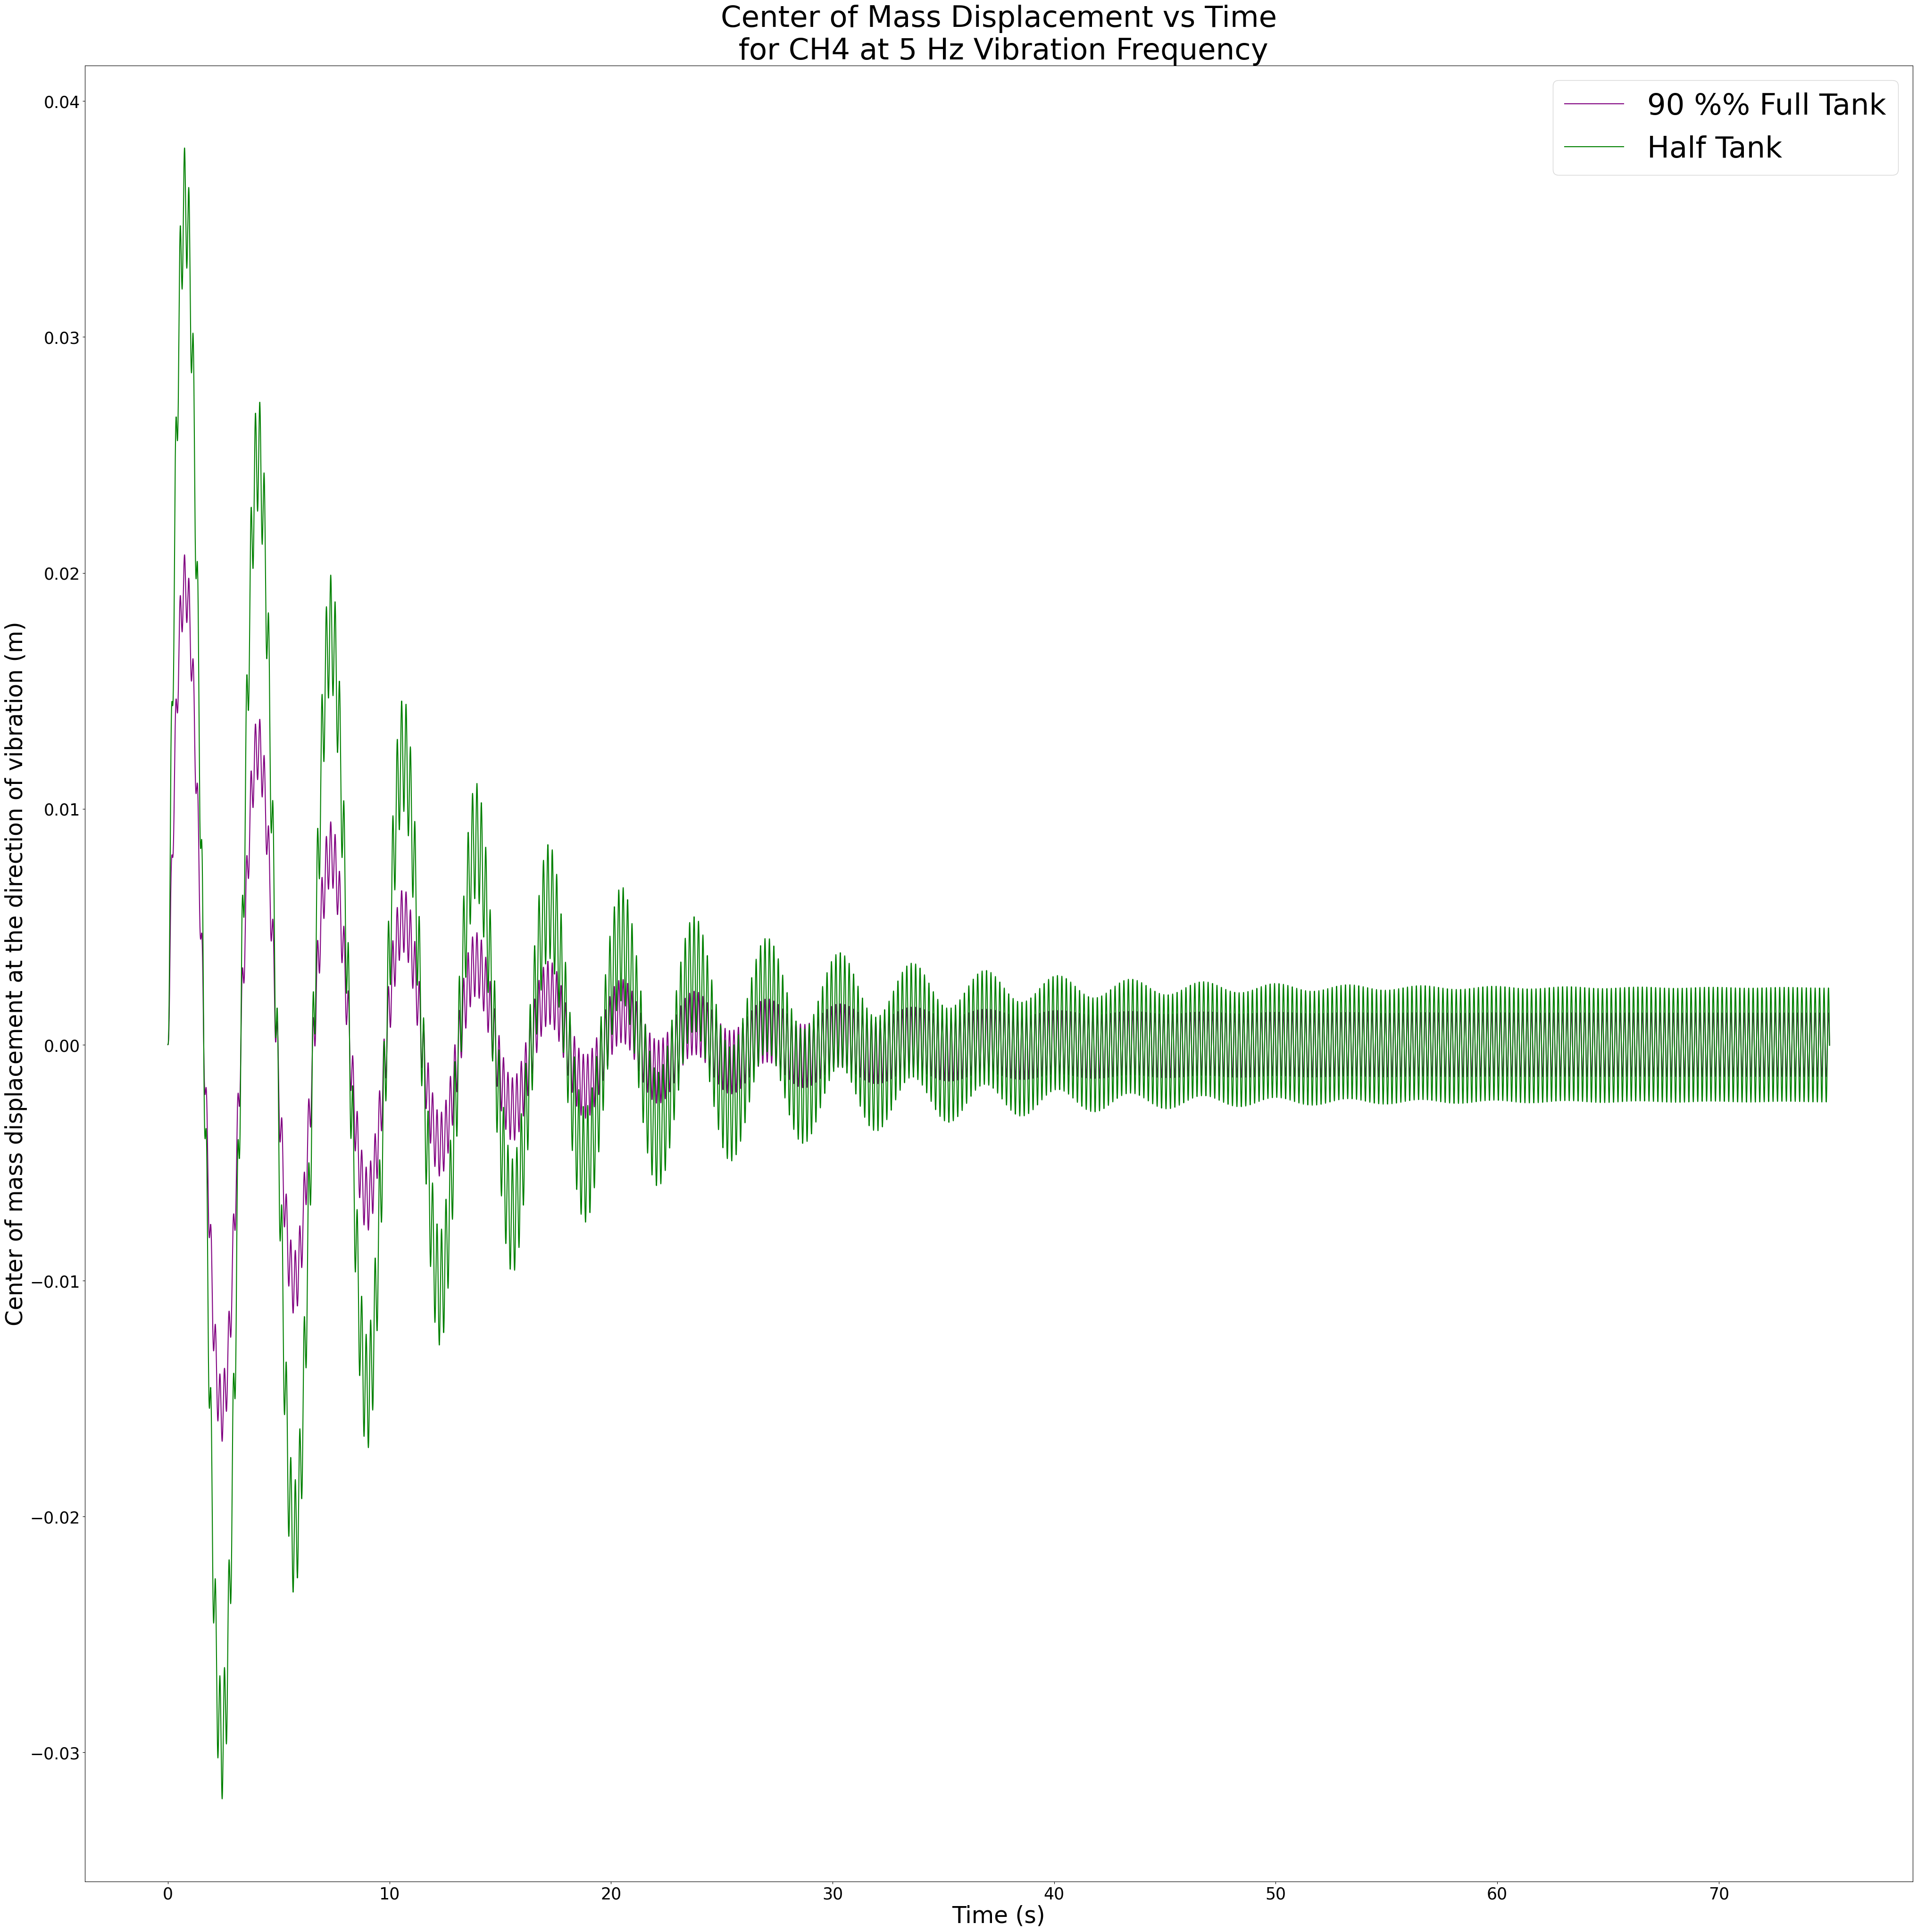

In [13]:
Matrix_CH4_half = Matrix(P_CH4,T_CH4,CH4_name,n_nodes,omega_array[ind],A_m_array[ind],0.5)
Matrix_CH4_full = Matrix(P_CH4,T_CH4,CH4_name,n_nodes,omega_array[ind],A_m_array[ind],0.1)

q_CH4_half,t_CH4_half,cm_CH4_half = Disp(Matrix_CH4_half,ind,Delta_t)
q_CH4_full,t_CH4_full,cm_CH4_full = Disp(Matrix_CH4_full,ind,Delta_t)


fig4,ax5 = plt.subplots(figsize=(50,50))

ax5.plot(t_CH4_full,cm_CH4_full,label = f"90 % Full Tank",color = "purple" )
ax5.plot(t_CH4_half,cm_CH4_half,label = "Half Tank",color = "green")

ax5.set_title(f"Center of Mass Displacement vs Time\n for CH4 at 5 Hz Vibration Frequency",fontsize = 45)
ax5.set_ylabel("Center of mass displacement at the direction of vibration (m)",fontsize = 35)
ax5.set_xlabel("Time (s)",fontsize = 35)
ax5.tick_params(axis='x', labelsize=25)
ax5.tick_params(axis='y', labelsize=25)
ax5.legend(fontsize = 45)



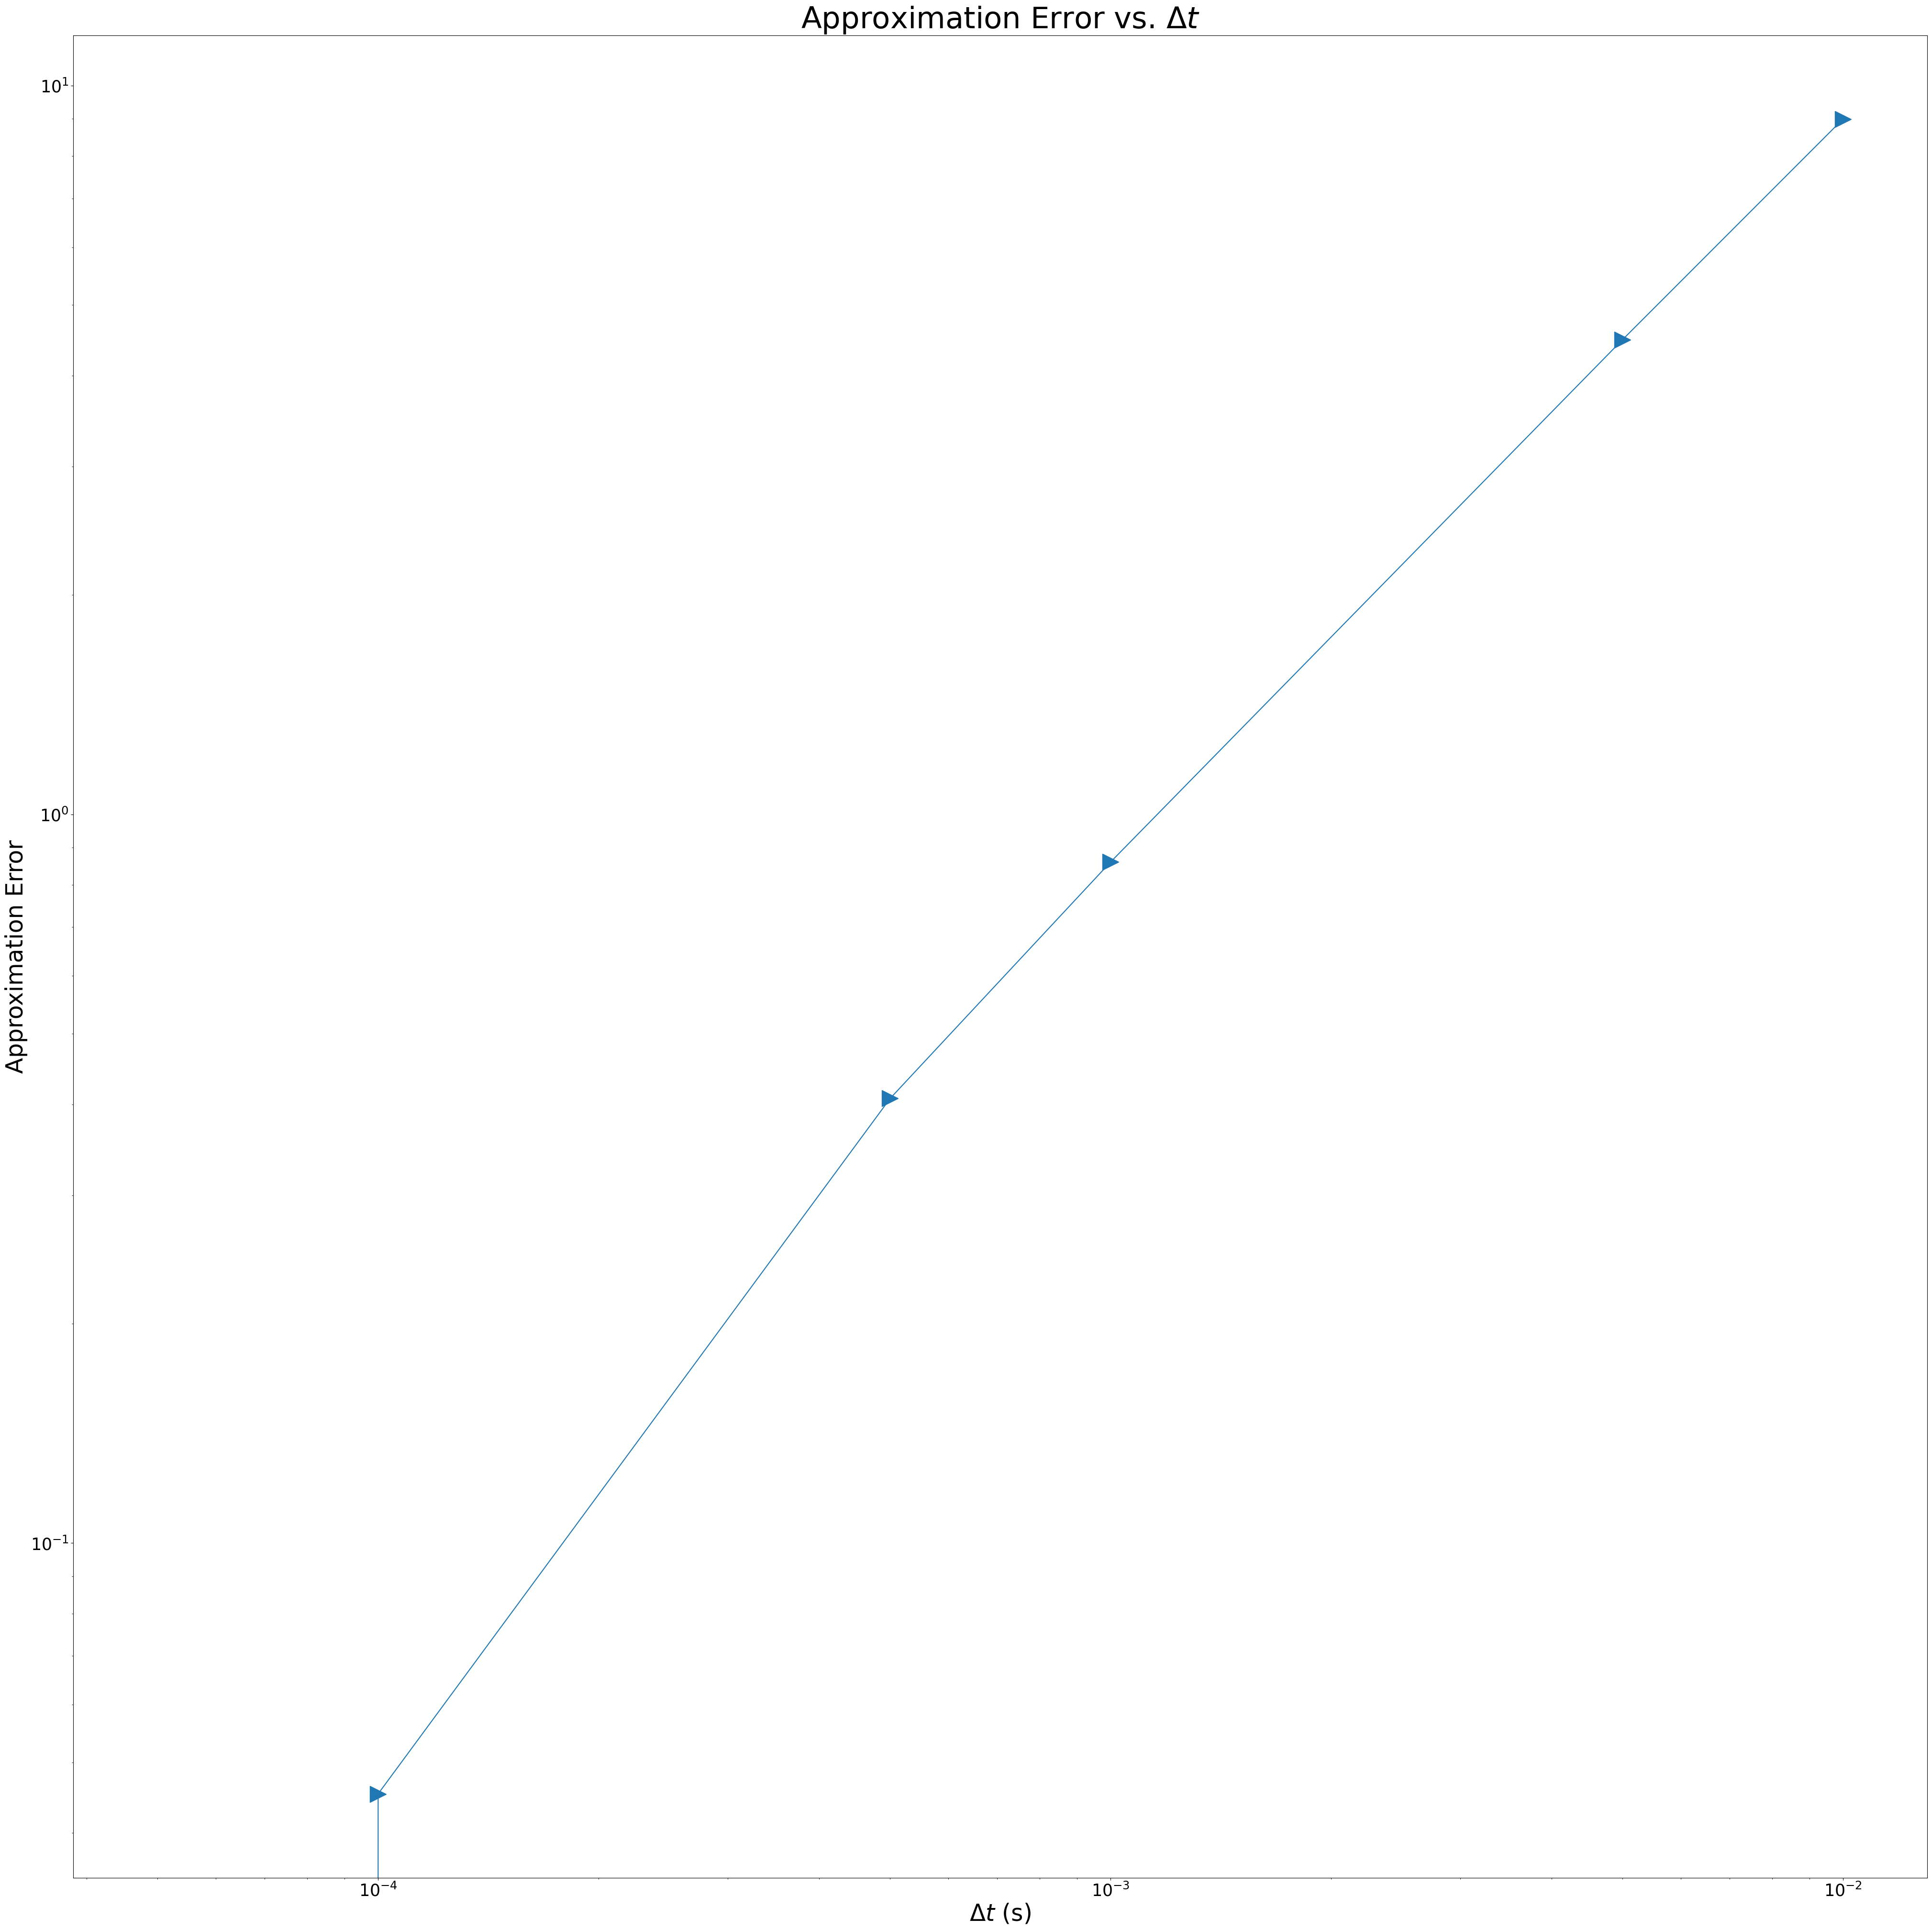

In [14]:
Delta_t_range = np.array([5e-5,1e-4,5e-4,1e-3,5e-3,1e-2])
Delta_t_base = 5e-5
err_O2 = RK4_error(Matrix_O2,ind,Delta_t_range,Delta_t_base)



fig5,ax6 = plt.subplots(figsize=(50,50))
ax6.plot(Delta_t_range,err_O2,marker =">",label =f"Err($\Delta t$)",markersize=25)
ax6.set_title("Approximation Error vs. $\Delta t$", fontsize= 45)
ax6.set_ylabel("Approximation Error",fontsize = 35)
ax6.set_xlabel("$\Delta t$ (s)",fontsize = 35)
ax6.set_yscale("log")
ax6.set_xscale("log")
ax6.tick_params(axis='x', labelsize=25)
ax6.tick_params(axis='y', labelsize=25)